In [25]:
# Import necessary packages

import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

# plt.rcParams['text.usetex'] = True

# EDA

In [26]:
# Read in csv

df = pd.read_csv('data/A3266_00-1111_all.csv')
df = df.drop('idn', axis=1) #Drop index column

#Some rows have inf values in them. Could replace inf with nan 
#or remove those rows. 
print("Positive infinity count:", (df == np.inf).sum().sum())
print("Negative infinity count:", (df == -np.inf).sum().sum())
df = df.replace([np.inf, -np.inf], np.nan)

# No Y mag data available for this cluster. Dropping four columns.
df = df.drop(['Y_psf_mag', 'Y_psf_magerr', 'Y_cmodel_mag', 'Y_cmodel_magerr',], axis=1)

Positive infinity count: 1996
Negative infinity count: 1


In [27]:
# Get shape and dtypes of df
print(f'(Rows, Columns): {df.shape}') #Print size of df
print(df.head(3)) #Show first 3 examples
print(df.dtypes) #Print attribute datatypes. All floats

# df.loc[df['e1'].notnull(), ['e1','e2', 'res','sigmae']]

(Rows, Columns): (1857685, 42)
          ra        dec             x            y  e1  e2  res  sigmae  \
0  68.914455 -62.906044  17394.772375  3890.481991 NaN NaN  NaN     NaN   
1  69.009523 -62.904732  16801.596400  3898.262765 NaN NaN  NaN     NaN   
2  68.977504 -62.904551  17001.230648  3904.279632 NaN NaN  NaN     NaN   

      rkron  extendedness  ...  r_cmodel_mag  r_cmodel_magerr  i_psf_mag  \
0  2.177848           1.0  ...     21.828693         0.031725  21.740775   
1  6.150654           1.0  ...     19.786428         0.011056  27.238589   
2  3.431714           1.0  ...     21.139035         0.020066  25.215983   

   i_psf_magerr  i_cmodel_mag  i_cmodel_magerr  z_psf_mag  z_psf_magerr  \
0      0.033023     21.712547         0.033202  21.778364      0.078916   
1      1.082054           NaN              NaN  25.915949      0.343267   
2      1.075873           NaN              NaN        NaN     -3.567432   

   z_cmodel_mag  z_cmodel_magerr  
0     21.738405         0.0

In [28]:
# Get stats of some features
# print(df['i_cmodel_mag'].describe()) 
# print(df['sigmae'].describe()) 
print(df['res'].describe()) 
# print(df['rkron'].describe()) 
# print(df['e1'].describe()) 
# print(df['e2'].describe()) 
# print(df['blendedness'].describe()) 

count    1.039798e+06
mean     4.151525e-01
std      2.618663e-01
min      1.015182e-07
25%      2.008439e-01
50%      4.061677e-01
75%      6.099436e-01
max      9.990225e-01
Name: res, dtype: float64


In [29]:
#Find out about missing feature data
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('Fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('Fraction of points with missing values:',frac_missing)

Fraction of missing values in features:
e1                 0.440272
e2                 0.440272
res                0.440272
sigmae             0.440272
rkron              0.024337
blendedness        0.072675
e1_sdss            0.012683
e2_sdss            0.012683
e1_psf_sdss        0.000003
e2_psf_sdss        0.000003
e1_hsm             0.072675
e2_hsm             0.072675
i_e1_psf_sdss      0.001066
i_e2_psf_sdss      0.001066
u_psf_mag          0.552664
u_psf_magerr       0.497406
u_cmodel_mag       0.553069
u_cmodel_magerr    0.500693
g_psf_mag          0.013114
g_psf_magerr       0.001309
g_cmodel_mag       0.013168
g_cmodel_magerr    0.002261
r_psf_mag          0.001882
r_cmodel_mag       0.001966
r_cmodel_magerr    0.000039
i_psf_mag          0.010033
i_psf_magerr       0.001159
i_cmodel_mag       0.011375
i_cmodel_magerr    0.003586
z_psf_mag          0.025147
z_psf_magerr       0.002125
z_cmodel_mag       0.028290
z_cmodel_magerr    0.007605
dtype: float64
Fraction of points wi

extendedness
1.0    1419960
0.0     437725
Name: count, dtype: int64
Class 0 (Star) Balance: 0.2356292912953488
Class 1 (Galaxy) Balance: 0.7643707087046512


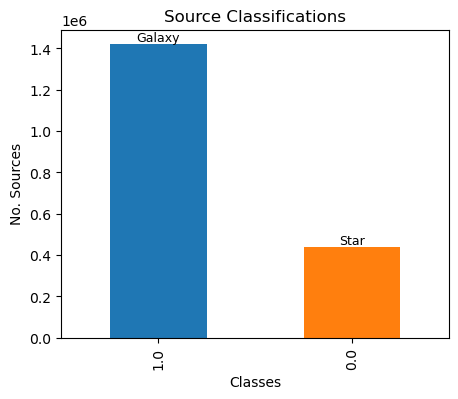

In [30]:
# Target variable info
print(df['extendedness'].value_counts())
print(f'Class 0 (Star) Balance: {df['extendedness'].value_counts()[0]/df.shape[0]}')
print(f'Class 1 (Galaxy) Balance: {df['extendedness'].value_counts()[1]/df.shape[0]}')

plt.figure(figsize = (5, 4))

# df['extendedness'].plot.hist()
ax = df['extendedness'].value_counts().plot.bar(color=['C0', 'C1'])
# plt.semilogx()
# plt.semilogy()
ax.bar_label(ax.containers[0], labels=['Galaxy', 'Star'], fontsize = 9)
plt.xlabel('Classes')
plt.ylabel('No. Sources')
plt.title('Source Classifications')
# plt.savefig('target_balance.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Other categorical features

print(df['psf_used'].value_counts())


psf_used
0.0    1805549
1.0      52136
Name: count, dtype: int64


In [9]:

# y = df['extendedness']
# X = df.loc[:, df.columns != 'extendedness']

# f_test, p_values = f_classif(X, y)
# print('f score',f_test)
# print('p values',p_values)

# mi = mutual_info_classif(X, y)
# print('mi',mi)

# correlation functions don't work due to nans.

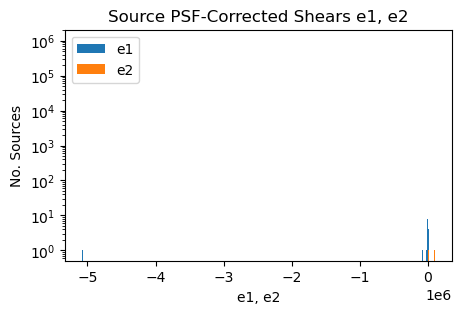

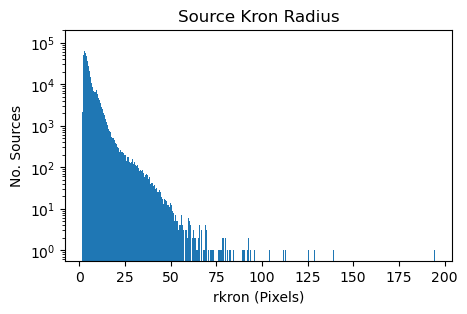

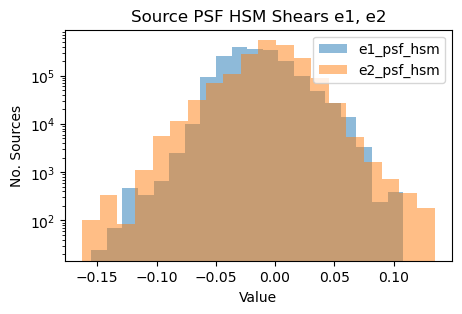

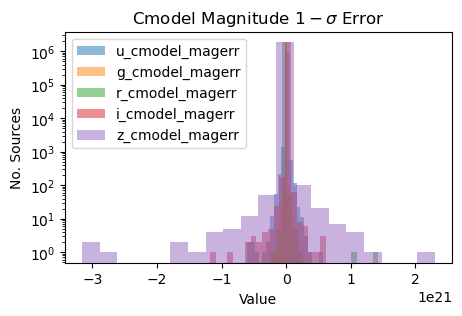

In [10]:
# Plotting features individually
   
#RA,DEC and x,y coordinates scatter plots
# fig, axs = plt.subplots(1, 2, figsize = (10,5))
# df.plot.scatter('x', 'y', ax = axs[0])
# axs[0].set_title('Centroid X,Y Positions')
# df.plot.scatter('ra', 'dec', ax = axs[1])
# axs[1].set_xlabel('Right Ascension (deg)')
# axs[1].set_ylabel('Declination (deg)')
# axs[1].set_title('RA,DEC Coordinates')

# plt.gca().invert_xaxis()
# fig.tight_layout()

# plt.show()


# # e1/e2 PSF corrected shear histograms. Continuous. Outliers
plt.figure(figsize = (5, 3))

df['e1'].plot.hist(bins = int(np.sqrt(df.shape[0])), label = 'e1')
df['e2'].plot.hist(bins = int(np.sqrt(df.shape[0])), label = 'e2')
# plt.semilogx()
plt.semilogy()
plt.legend()
plt.xlabel('e1, e2')
plt.ylabel('No. Sources')
plt.title('Source PSF-Corrected Shears e1, e2')
plt.show()


#res = resolution factor. histogram. Feature is continuous [0,1]
# plt.figure(figsize = (5, 3))

# df['res'].plot.hist(bins = 20)
# # plt.semilogx()
# plt.semilogy()
# plt.xlabel('res')
# plt.ylabel('No. Sources')
# plt.title('Resolution Factor')
# plt.show()


#sigmae histogram. Feature is continuous. Outliers present
# plt.figure(figsize = (5, 3))

# df['sigmae'].plot.hist(bins = int(np.sqrt(df.shape[0])))
# plt.semilogx()
# plt.semilogy()
# # plt.xlim(0.1, 1e15)
# plt.xlabel('sigmae')
# plt.ylabel('No. Sources')
# plt.title('Resolution Factor')
# plt.show()

# rkron histogram. Continuous. NOT SURE ABOUT UNITS??
plt.figure(figsize = (5, 3))

df['rkron'].plot.hist(bins = int(np.sqrt(df.shape[0])))
# plt.semilogx()
plt.semilogy()
plt.xlabel('rkron (Pixels)')
plt.ylabel('No. Sources')
plt.title('Source Kron Radius')
plt.show()


# blendedness histogram. Continuous on [0,1]. OUTLIERS, some with val < 0.
# plt.figure(figsize = (5, 3))

# df['blendedness'].plot.hist(bins = int(np.sqrt(df.shape[0])))
# # plt.semilogx()
# plt.semilogy()
# plt.xlabel('blendedness')
# plt.ylabel('No. Sources')
# plt.title('Source Blendedness')
# plt.show()


#psf_used bar plot. Categorical. 0 = No, 1 = Yes
# plt.figure(figsize = (5, 4))

# ax = df['psf_used'].value_counts().plot.bar()
# # plt.semilogx()
# # plt.semilogy()
# ax.bar_label(ax.containers[0], labels=['No', 'Yes'], fontsize = 8)
# plt.xlabel('psf_used')
# plt.ylabel('No. Sources')
# plt.title('Source PSF Used?')
# plt.show()



# # e1_sdss/e2_sdss histograms. Continuous. Outliers present
# plt.figure(figsize = (5, 3))

# df['e1_sdss'].plot.hist(bins = int(np.sqrt(df.shape[0])), label = 'e1_sdss', alpha = 0.5)
# df['e2_sdss'].plot.hist(bins = int(np.sqrt(df.shape[0])), label = 'e2_sdss', alpha = 0.5)
# # plt.semilogx()
# plt.semilogy()
# plt.legend()
# plt.xlabel('Value')
# plt.ylabel('No. Sources')
# plt.title('Source SDSS Shears e1, e2')
# plt.show()

# # e1_psf_sdss/e2_psf_sdss histograms. Continuous. Outliers?
# plt.figure(figsize = (5, 3))

# df['e1_psf_sdss'].plot.hist(bins = 20, label = 'e1_psf_sdss', alpha = 0.5)
# df['e2_psf_sdss'].plot.hist(bins = 20, label = 'e2_psf_sdss', alpha = 0.5)
# # plt.semilogx()
# plt.semilogy()
# plt.legend()
# plt.xlabel('Value')
# plt.ylabel('No. Sources')
# plt.title('Source PSF SDSS Shears e1, e2')
# plt.show()


# # e1_hsm/e2_hsm histograms. Continuous [0,1]
# plt.figure(figsize = (5, 3))

# df['e1_hsm'].plot.hist(bins = 20, label = 'e1_hsm', alpha = 0.5)
# df['e2_hsm'].plot.hist(bins = 20, label = 'e2_hsm', alpha = 0.5)
# # plt.semilogx()
# plt.semilogy()
# plt.legend()
# plt.xlabel('Value')
# plt.ylabel('No. Sources')
# plt.title('Source HSM Shears e1, e2')
# plt.show()

# # e1_psf_hsm/e2_psf_hsm histograms. Continuous. Outliers?
plt.figure(figsize = (5, 3))

df['e1_psf_hsm'].plot.hist(bins = 20, label = 'e1_psf_hsm', alpha = 0.5)
df['e2_psf_hsm'].plot.hist(bins = 20, label = 'e2_psf_hsm', alpha = 0.5)
# plt.semilogx()
plt.semilogy()
plt.legend()
plt.xlabel('Value')
plt.ylabel('No. Sources')
plt.title('Source PSF HSM Shears e1, e2')
plt.show()



# # i_e1_psf_sdss/i_e2_psf_sdss histograms. Continuous. Outliers
# plt.figure(figsize = (5, 3))

# df['i_e1_psf_sdss'].plot.hist(bins = 20, label = 'i_e1_psf_sdss', alpha = 0.5)
# df['i_e2_psf_sdss'].plot.hist(bins = 20, label = 'i_e2_psf_sdss', alpha = 0.5)
# # plt.semilogx()
# plt.semilogy()
# plt.legend()
# plt.xlabel('Value')
# plt.ylabel('No. Sources')
# plt.title('Source i-Band PSF SDSS Shears e1, e2')
# plt.show()



# # PSF magnitude histograms. Continuous. Outliers in high mag?
# plt.figure(figsize = (5, 3))

# df['u_psf_mag'].plot.hist(bins = 20, label = 'u_psf_mag', alpha = 0.5)
# df['g_psf_mag'].plot.hist(bins = 20, label = 'g_psf_mag', alpha = 0.5)
# df['r_psf_mag'].plot.hist(bins = 20, label = 'r_psf_mag', alpha = 0.5)
# df['i_psf_mag'].plot.hist(bins = 20, label = 'i_psf_mag', alpha = 0.5)
# df['z_psf_mag'].plot.hist(bins = 20, label = 'z_psf_mag', alpha = 0.5)
# # plt.semilogx()
# plt.semilogy()
# plt.legend()
# plt.xlabel('Value')
# plt.ylabel('No. Sources')
# plt.title('PSF Magnitudes')
# plt.show()

# # PSF error magnitude histograms. Continuous. Outliers in high mag and negative.
# plt.figure(figsize = (5, 3))

# df['u_psf_magerr'].plot.hist(bins = 20, label = 'u_psf_magerr', alpha = 0.5)
# df['g_psf_magerr'].plot.hist(bins = 20, label = 'g_psf_magerr', alpha = 0.5)
# df['r_psf_magerr'].plot.hist(bins = 20, label = 'r_psf_magerr', alpha = 0.5)
# df['i_psf_magerr'].plot.hist(bins = 20, label = 'i_psf_magerr', alpha = 0.5)
# df['z_psf_magerr'].plot.hist(bins = 20, label = 'z_psf_magerr', alpha = 0.5)
# # plt.semilogx()
# plt.semilogy()
# plt.legend()
# plt.xlabel('Value')
# plt.ylabel('No. Sources')
# plt.title(r'PSF Magnitude $1-\sigma$ Error')
# plt.show()



# # cmodel magnitude histograms. Continuous. Outliers in high mag?
# plt.figure(figsize = (5, 3))

# df['u_cmodel_mag'].plot.hist(bins = 20, label = 'u_cmodel_mag', alpha = 0.5)
# df['g_cmodel_mag'].plot.hist(bins = 20, label = 'g_cmodel_mag', alpha = 0.5)
# df['r_cmodel_mag'].plot.hist(bins = 20, label = 'r_cmodel_mag', alpha = 0.5)
# df['i_cmodel_mag'].plot.hist(bins = 20, label = 'i_cmodel_mag', alpha = 0.5)
# df['z_cmodel_mag'].plot.hist(bins = 20, label = 'z_cmodel_mag', alpha = 0.5)
# # plt.semilogx()
# plt.semilogy()
# plt.legend()
# plt.xlabel('Value')
# plt.ylabel('No. Sources')
# plt.title('Cmodel Magnitudes')
# plt.show()


# cmodel magnitude error histograms. Continuous. Outliers in high mag and negative
plt.figure(figsize = (5, 3))

df['u_cmodel_magerr'].plot.hist(bins = 20, label = 'u_cmodel_magerr', alpha = 0.5)
df['g_cmodel_magerr'].plot.hist(bins = 20, label = 'g_cmodel_magerr', alpha = 0.5)
df['r_cmodel_magerr'].plot.hist(bins = 20, label = 'r_cmodel_magerr', alpha = 0.5)
df['i_cmodel_magerr'].plot.hist(bins = 20, label = 'i_cmodel_magerr', alpha = 0.5)
df['z_cmodel_magerr'].plot.hist(bins = 20, label = 'z_cmodel_magerr', alpha = 0.5)
# plt.semilogx()
plt.semilogy()
plt.legend()
plt.xlabel('Value')
plt.ylabel('No. Sources')
plt.title(r'Cmodel Magnitude $1-\sigma$ Error')
plt.show()



# plt.figure(figsize = (5, 3))

# df['u_cmodel_mag'].plot.hist(bins = int(np.sqrt(df.shape[0])))
# # plt.semilogx()
# plt.semilogy()
# plt.xlabel('u_cmodel_mag')
# plt.ylabel('No. Sources')
# plt.title('Source u-Band Magnitudes')
# plt.show()


# print(df.loc[df['e1'] < -1e6]) #This is the row wit e1 having an extremely negative value





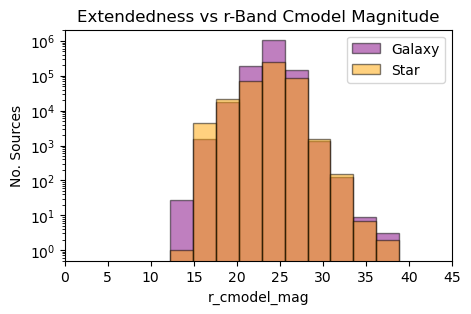

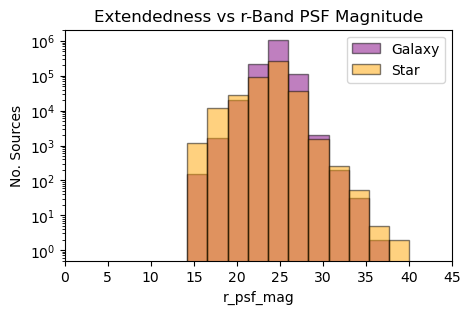

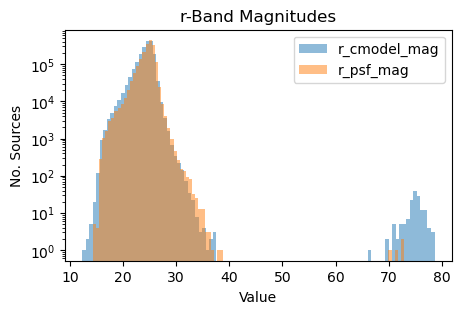

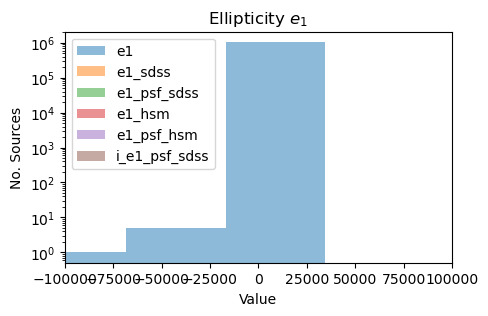

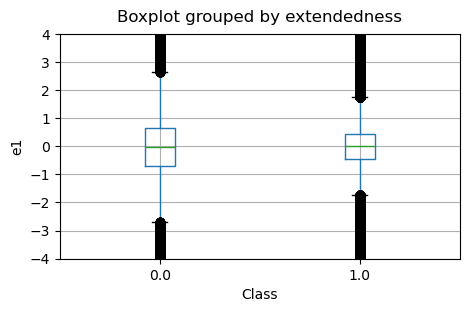

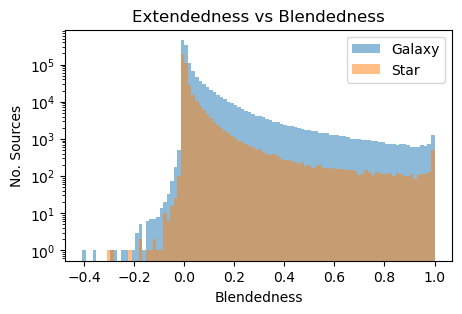

<Figure size 500x300 with 0 Axes>

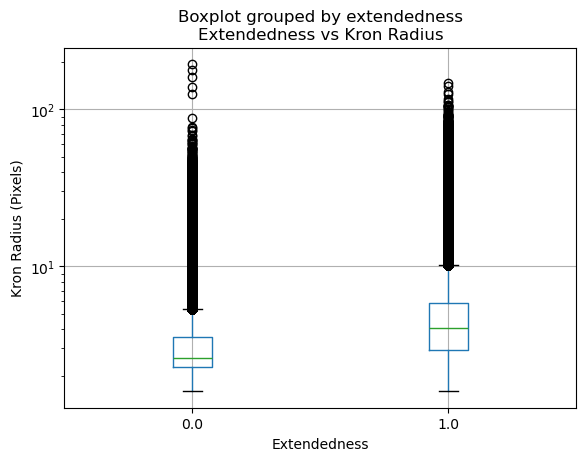

<Figure size 500x300 with 0 Axes>

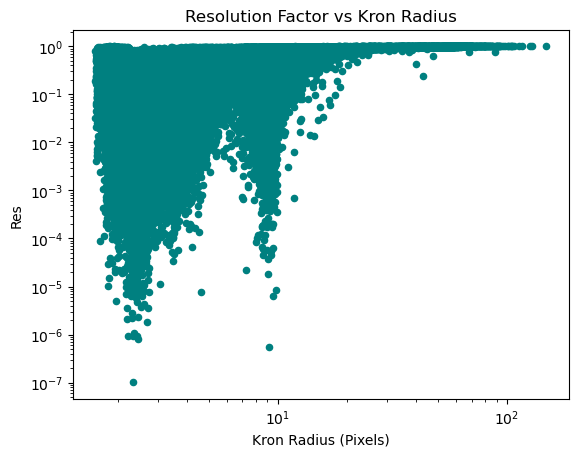

[  1.59783781   5.26663553   8.93543325  12.60423097  16.2730287
  19.94182642  23.61062414  27.27942186  30.94821959  34.61701731
  38.28581503  41.95461275  45.62341048  49.2922082   52.96100592
  56.62980364  60.29860137  63.96739909  67.63619681  71.30499453
  74.97379225  78.64258998  82.3113877   85.98018542  89.64898314
  93.31778087  96.98657859 100.65537631 104.32417403 107.99297176
 111.66176948 115.3305672  118.99936492 122.66816265 126.33696037
 130.00575809 133.67455581 137.34335354 141.01215126 144.68094898
 148.3497467 ] [1.01518168e-07 2.49756626e-02 4.99512236e-02 7.49267847e-02
 9.99023457e-02 1.24877907e-01 1.49853468e-01 1.74829029e-01
 1.99804590e-01 2.24780151e-01 2.49755712e-01 2.74731273e-01
 2.99706834e-01 3.24682395e-01 3.49657956e-01 3.74633517e-01
 3.99609078e-01 4.24584639e-01 4.49560200e-01 4.74535761e-01
 4.99511322e-01 5.24486884e-01 5.49462445e-01 5.74438006e-01
 5.99413567e-01 6.24389128e-01 6.49364689e-01 6.74340250e-01
 6.99315811e-01 7.24291372e-01 

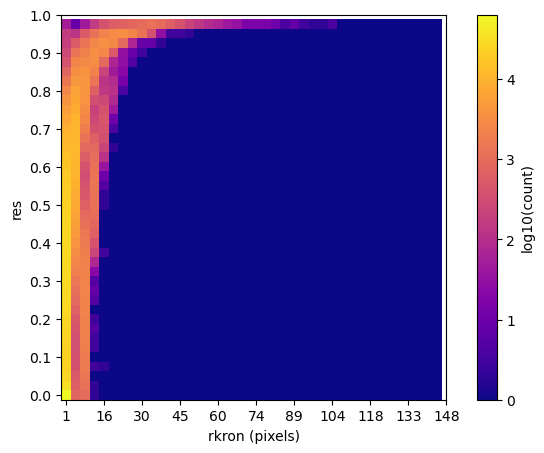

In [35]:
# Compare a magnitude with extendedness (category-specific histogram)

plt.figure(figsize = (5, 3))

categories = df['extendedness'].unique()
bin_range = (df['r_cmodel_mag'].min(),df['r_cmodel_mag'].max())

colors = ['purple', 'orange']

for i,c in enumerate(categories):
    plt.hist(df[df['extendedness']==c]['r_cmodel_mag'],alpha=0.5,label=c, \
             edgecolor='black', range=bin_range,bins=25,density=False, \
            color = colors[i])

# plt.semilogx()
plt.semilogy()
plt.xlim(0,45)
plt.legend(["Galaxy", "Star"])
plt.xlabel('r_cmodel_mag')
plt.ylabel('No. Sources')
plt.title('Extendedness vs r-Band Cmodel Magnitude')
plt.show()


# Compare a magnitude with extendedness (category-specific histogram)

plt.figure(figsize = (5, 3))

categories = df['extendedness'].unique()
bin_range = (df['r_psf_mag'].min(),df['r_psf_mag'].max())

colors = ['purple', 'orange']

for i,c in enumerate(categories):
    plt.hist(df[df['extendedness']==c]['r_psf_mag'],alpha=0.5,label=c, \
             edgecolor='black', range=bin_range,bins=25,density=False, \
            color = colors[i])

# plt.semilogx()
plt.semilogy()
plt.xlim(0,45)
plt.legend(["Galaxy", "Star"])
plt.xlabel('r_psf_mag')
plt.ylabel('No. Sources')
plt.title('Extendedness vs r-Band PSF Magnitude')
plt.show()



# Compare a single band magnitude across all measurements

plt.figure(figsize = (5, 3))

df['r_cmodel_mag'].plot.hist(bins = 100, label = 'r_cmodel_mag', alpha = 0.5)
df['r_psf_mag'].plot.hist(bins = 100, label = 'r_psf_mag', alpha = 0.5)
# plt.semilogx()
plt.semilogy()
plt.legend()
plt.xlabel('Value')
plt.ylabel('No. Sources')
plt.title(r'r-Band Magnitudes')
plt.show()

# Compare e1 across all measurements

plt.figure(figsize = (5, 3))

df['e1'].plot.hist(bins = 100, label = 'e1', alpha = 0.5)
df['e1_sdss'].plot.hist(bins = 100, label = 'e1_sdss', alpha = 0.5)
df['e1_psf_sdss'].plot.hist(bins = 100, label = 'e1_psf_sdss', alpha = 0.5)
df['e1_hsm'].plot.hist(bins = 100, label = 'e1_hsm', alpha = 0.5)
df['e1_psf_hsm'].plot.hist(bins = 100, label = 'e1_psf_hsm', alpha = 0.5)
df['i_e1_psf_sdss'].plot.hist(bins = 100, label = 'i_e1_psf_sdss', alpha = 0.5)
# plt.semilogx()
plt.semilogy()
plt.legend()
plt.xlim(-1e5, 1e5)
plt.xlabel('Value')
plt.ylabel('No. Sources')
plt.title(r'Ellipticity $e_1$')
plt.show()



df[['e1','extendedness']].boxplot(by='extendedness',figsize=(5,3))
plt.ylim(-4,4)
plt.ylabel('e1')
plt.xlabel('Class')
plt.title('')
plt.savefig('target_e1_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Blendedness vs Extendedness (target variable)
plt.figure(figsize = (5, 3))

categories = df['extendedness'].unique()
bin_range = (df['blendedness'].min(),df['blendedness'].max())

for c in categories:
    plt.hist(df[df['extendedness']==c]['blendedness'],alpha=0.5,label=c,range=bin_range,bins=100,density=False)

# plt.semilogx()
plt.semilogy()
plt.legend(["Galaxy", "Star"])
plt.xlabel('Blendedness')
plt.ylabel('No. Sources')
plt.title('Extendedness vs Blendedness')
plt.show()

# Kron Radius vs Extendedness (target variable)
plt.figure(figsize = (5, 3))

# categories = df['extendedness'].unique()
# bin_range = (df['rkron'].min(),df['rkron'].max())

# for c in categories:
#     plt.hist(df[df['extendedness']==c]['rkron'],alpha=0.5,label=c,range=bin_range,bins=100,density=False)

df[['extendedness', 'rkron']].boxplot(by = 'extendedness')
# # plt.semilogx()
plt.semilogy()
# plt.legend(["Galaxy", "Star"])
plt.xlabel('Extendedness')
plt.ylabel('Kron Radius (Pixels)')
plt.title('Extendedness vs Kron Radius')
plt.show()



#res and kron radius. Continuous vs continuous 
plt.figure(figsize = (5, 3))
# fig, axs = plt.subplots(1, 2, figsize = (10,5))
df.plot.scatter('rkron', 'res', color = 'teal')
plt.semilogx()
plt.semilogy()
plt.xlabel('Kron Radius (Pixels)')
plt.ylabel('Res')
plt.title('Resolution Factor vs Kron Radius')
# df.plot.scatter('ra', 'dec', ax = axs[1])
# axs[1].set_xlabel('Right Ascension (deg)')
# axs[1].set_ylabel('Declination (deg)')
# axs[1].set_title('RA,DEC Coordinates')

# plt.gca().invert_xaxis()
# fig.tight_layout()

plt.show()


nbins = 40

df_clean = df[['rkron', 'res']].dropna()
heatmap, xedges, yedges = np.histogram2d(df_clean['rkron'], df_clean['res'], bins=nbins)
print(xedges, yedges)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

heatmap[heatmap == 0] = 0.1 # we will use log and log(0) is undefined
plt.figure(figsize=(8,5))

plt.imshow(np.log10(heatmap).T, origin='lower',vmin=0, cmap = 'plasma') # use log count
# plt.imshow(heatmap.T, origin='lower',vmin=0) # use log count
plt.xlabel('rkron (pixels)')
plt.ylabel('res')
# plt.xlim(0, 100)
plt.xticks(np.arange(nbins+1)[::4],xedges[::4].astype(int))
plt.yticks(np.arange(nbins+1)[::4],[f'{tick:.1f}' for tick in yedges[::4]])
plt.colorbar(label='log10(count)')
# plt.imsave('res_rkron_cmap.png', image)
plt.savefig('res_rkron_cmap.png', dpi=1000)
plt.show()

# fig = go.Figure(data=go.Heatmap(
#     z=heatmap,
#     x=xedges,
#     y=yedges,
#     colorscale='Viridis'))

# # Add labels and title
# fig.update_layout(
#     title='Heatmap of Column 1 vs Column 2',
#     xaxis_title='Column 1',
#     yaxis_title='Column 2'
# )

# # Show the plot
# fig.show()

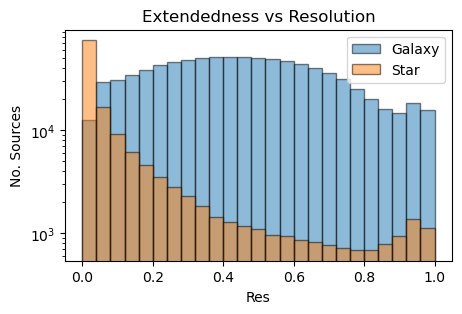

In [31]:
# Feature vs Extendedness (target variable)
plt.figure(figsize = (5, 3))

categories = df['extendedness'].unique()
bin_range = (df['res'].min(),df['res'].max())

for c in categories:
    plt.hist(df[df['extendedness']==c]['res'],alpha=0.5,label=c, \
             range=bin_range,bins=25, \
             edgecolor='black',density=False)

# plt.semilogx()
plt.semilogy()
plt.legend(["Galaxy", "Star"])
plt.xlabel('Res')
plt.ylabel('No. Sources')
plt.title('Extendedness vs Resolution')
# plt.savefig('target_vs_res.png', dpi=300, bbox_inches='tight')
plt.show()

# Maybe res. Rkron slightly. u_psf_mag (and magerr), g, i, z has a bump for galaxys not seen in stars.

# Feature Engineering

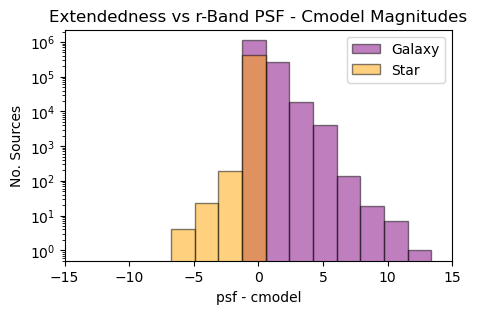

Fraction of missing values in features:
e1                 0.440272
e2                 0.440272
res                0.440272
sigmae             0.440272
rkron              0.024337
blendedness        0.072675
e1_sdss            0.012683
e2_sdss            0.012683
e1_psf_sdss        0.000003
e2_psf_sdss        0.000003
e1_hsm             0.072675
e2_hsm             0.072675
i_e1_psf_sdss      0.001066
i_e2_psf_sdss      0.001066
u_psf_mag          0.552664
u_psf_magerr       0.497406
u_cmodel_mag       0.553069
u_cmodel_magerr    0.500693
g_psf_mag          0.013114
g_psf_magerr       0.001309
g_cmodel_mag       0.013168
g_cmodel_magerr    0.002261
r_psf_mag          0.001882
r_cmodel_mag       0.001966
r_cmodel_magerr    0.000039
i_psf_mag          0.010033
i_psf_magerr       0.001159
i_cmodel_mag       0.011375
i_cmodel_magerr    0.003586
z_psf_mag          0.025147
z_psf_magerr       0.002125
z_cmodel_mag       0.028290
z_cmodel_magerr    0.007605
u_mag_diff         0.563906
g_mag_di

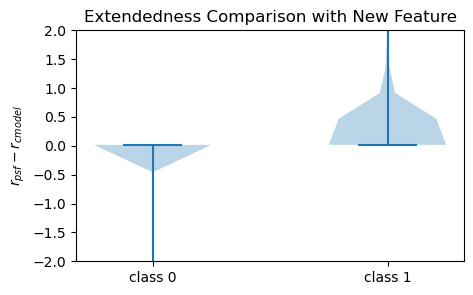

In [33]:
#Difference in psf and cmodel mags may be a better predictor of extendedness

u_diff = df['u_psf_mag'] - df['u_cmodel_mag']
g_diff = df['g_psf_mag'] - df['g_cmodel_mag']
r_diff = df['r_psf_mag'] - df['r_cmodel_mag'] #HUGE DIFFERENCE 
i_diff = df['i_psf_mag'] - df['i_cmodel_mag']
z_diff = df['z_psf_mag'] - df['z_cmodel_mag']

df["u_mag_diff"] = u_diff; df["g_mag_diff"] = g_diff; df["r_mag_diff"] = r_diff
df["i_mag_diff"] = i_diff; df["z_mag_diff"] = z_diff 

# Compare a (psf - cmodel) magnitude with extendedness (category-specific histogram)

plt.figure(figsize = (5, 3))

categories = df['extendedness'].unique()
bin_range = (r_diff.min(),r_diff.max())

colors = ['purple', 'orange']

for i,c in enumerate(categories):
    plt.hist(df[df['extendedness']==c]['r_mag_diff'],alpha=0.5, \
             label=c,range=bin_range,bins = 50,density=False, \
            edgecolor='black', color=colors[i])

# plt.semilogx()
plt.semilogy()
# plt.xlim(0.1, 1e5)
plt.xlim(-15, 15)
plt.legend(["Galaxy", "Star"])
plt.xlabel('psf - cmodel')
plt.ylabel('No. Sources')
plt.title('Extendedness vs r-Band PSF - Cmodel Magnitudes')
# plt.title(r'Extendedness vs $\gamma = \sqrt{e_1^2 + e_2^2}$')
# plt.savefig('target_vs_rmagdiff.png', dpi=300, bbox_inches='tight')
plt.show()

#Find out about missing feature data
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('Fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('Fraction of points with missing values:',frac_missing)

print(df[df['extendedness']==0]['r_mag_diff'].dropna().shape[0])
print(df[df['extendedness']==1]['r_mag_diff'].dropna().shape[0])
dataset = [df[df['extendedness']==0]['r_mag_diff'].dropna(),
           df[df['extendedness']==1]['r_mag_diff'].dropna()]

plt.figure(figsize=(5,3))
plt.violinplot(dataset = dataset)
# plt.semilogy()
# plt.yscale('symlog', linthresh=0.01)
plt.ylim(-2,2)
plt.xticks([1,2],['class 0','class 1'])
plt.ylabel(r'$r_{psf} - r_{cmodel}$')
plt.title('Extendedness Comparison with New Feature')
plt.show()

#Tried gamma = sqrt(e1^2 + e^2) but it's not good
# gamma_e1_e2 = np.sqrt(df['e1']**2 + df['e2']**2)
# print(gamma_e1_e2)
# print(f'NaN count: {gamma_e1_e2.isna().sum()}')
# print(gamma_e1_e2.shape[0])
# print(f'Proportion of nans in gamma_e1_e2: {gamma_e1_e2.isna().sum()/gamma_e1_e2.shape[0]}')

# Data Splitting 

In [14]:
# Split target from feature matrix
y = df['extendedness']
X = df.loc[:, df.columns != 'extendedness']

print(X.shape); print(y.shape)


random_state = 52 # Reproducibility

# 60/20/20 split on train/val/test
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=random_state)
print('Stratified Balance')
# very little variation (in the 4th decimal point only) which is important if the problem is imbalanced
print(np.unique(y_train,return_counts=True))
print(np.unique(y_val,return_counts=True))
print(np.unique(y_test,return_counts=True))

(1857685, 46)
(1857685,)
Stratified Balance
(array([0., 1.]), array([262635, 851976]))
(array([0., 1.]), array([ 87545, 283992]))
(array([0., 1.]), array([ 87545, 283992]))


# Preprocessing

In [15]:
# collect which encoder to use on each feature
# needs to be done manually

minmax_ftrs = ['ra','dec','x','y','e1','e2','res','blendedness','e1_sdss','e2_sdss','e1_psf_sdss','e2_psf_sdss', \
              'e1_hsm','e2_hsm','e1_psf_hsm','e2_psf_hsm','i_e1_psf_sdss','i_e2_psf_sdss']
std_ftrs = ['sigmae','rkron','u_psf_mag','u_psf_magerr','u_cmodel_mag','u_cmodel_magerr', \
           'g_psf_mag','g_psf_magerr','g_cmodel_mag','g_cmodel_magerr', \
           'r_psf_mag','r_psf_magerr','r_cmodel_mag','r_cmodel_magerr', \
           'i_psf_mag','i_psf_magerr','i_cmodel_mag','i_cmodel_magerr', \
           'z_psf_mag','z_psf_magerr','z_cmodel_mag','z_cmodel_magerr', \
           'u_mag_diff','g_mag_diff','r_mag_diff','i_mag_diff','z_mag_diff']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)], \
    remainder = 'passthrough') #psf_used is already OHE, so pass it through

clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)


# collect feature names
feature_names = clf.get_feature_names_out()

df_train_prep = pd.DataFrame(data=X_train_prep,columns=feature_names)
print(f'preprocessed train size: {df_train_prep.shape}')

df_val_prep = pd.DataFrame(data=X_val_prep,columns = feature_names)
print(f'preprocessed validation size: {df_val_prep.shape}')

df_test_prep = pd.DataFrame(data=X_test_prep,columns = feature_names)
print(f'preprocessed test size: {df_test_prep.shape}')

print(X_train.shape)
print(X_train_prep.shape)
# print(X_train_prep)

preprocessed train size: (1114611, 46)
preprocessed validation size: (371537, 46)
preprocessed test size: (371537, 46)
(1114611, 46)
(1114611, 46)


df_*_prep are dfs of the feature (X) data AFTER preprocessing. 46 columns each. This data still has NaNs. Below I'll create the same dfs but with imputed data using sklearn's iterative imputer

In [16]:
# imputer = IterativeImputer(max_iter=20, tol=1e-1, random_state=random_state)

# X_train_impute = imputer.fit_transform(df_train_prep)
# df_train_imp = pd.DataFrame(data=X_train_impute, columns = df_train_prep.columns)

# df_val_imp = pd.DataFrame(data=imputer.transform(df_val_prep), columns = df_val_prep.columns)
# df_test_imp = pd.DataFrame(data=imputer.transform(df_test_prep), columns = df_test_prep.columns)

# print(df_train_imp.shape)
# print(df_val_imp.shape)
# print(df_test_imp.shape)

# print(df_train_imp.isnull().values.any())
# print(df_val_imp.isnull().values.any())
# print(df_test_imp.isnull().values.any())

Taking a look at feature importances for TRAINING dfs. First df with NaN but Exluding NaN. Then, using imputed df

In [17]:
# Using df with NaN, but exluding rows with NaN

nan_row_indices = ~df_train_prep.isnull().any(axis=1)

# print(nan_row_indices)
# print(df_train_prep[nan_row_indices])
# print(y_train[nan_row_indices.to_numpy()])

f_stat_prep, p_val_prep = f_classif(df_train_prep[nan_row_indices], y_train[nan_row_indices.to_numpy()])
print('f score',f_stat_prep)
print('p values',p_val_prep)

mi_prep = mutual_info_classif(df_train_prep[nan_row_indices], y_train[nan_row_indices.to_numpy()])
print('mi',mi_prep)

f score [1.17468290e+02 2.81845951e+01 1.17277938e+02 2.89191681e+01
 4.16523314e-01 1.21537889e+01 7.52558074e+04 1.56552532e+03
 1.06516136e+02 3.47183592e+01 2.08382967e+00 2.49498307e+00
 1.02430051e+02 3.51533459e+01 1.99583460e+00 2.59540284e+00
 1.61050930e+01 7.75415537e-01 1.71678891e+02 5.68176268e+03
 3.83588797e+03 7.02975587e-01 7.59092944e+00 4.50633179e+01
 1.66125480e+04 2.65983114e-01 2.32193556e+03 6.35340383e+01
 1.83113023e+04 2.01119321e+01 4.06243368e+03 7.18090027e+00
 1.42713130e+04 2.62402089e-01 2.24329793e+03 6.76187457e+01
 1.15365961e+04 1.49893599e+00 1.11941546e+03 2.50830653e+01
 8.14967231e+02 5.94382159e+03 2.81354578e+04 9.47082404e+03
 6.70086110e+03 5.80194818e+04]
p values [2.29250125e-027 1.10353682e-007 2.52333440e-027 7.55163066e-008
 5.18677434e-001 4.89949527e-004 0.00000000e+000 0.00000000e+000
 5.73548049e-025 3.81409190e-009 1.48867275e-001 1.14210615e-001
 4.50704229e-024 3.05055216e-009 1.57733149e-001 1.07175195e-001
 5.99365946e-005 3.7

In [18]:
# Using df with imputed data

# f_stat_imp, p_val_imp = f_classif(df_train_imp, y_train)
# print('f score',f_stat_imp)
# print('p values',p_val_imp)

# mi_imp = mutual_info_classif(df_train_imp, y_train)
# print('mi',mi_imp)

# ML Models

## Logistic Regression

In [19]:
def logreg_split_logloss(X, y, param_grid, minmax_ftrs, std_ftrs, num_states):
    '''
    This function splits the data to train/val/test 60/20/20
    elastic net (l1,l2) is used as penalty
    Accuracy is used as evaluation metric 

    1. Loop through n different random states
    2. Split data 
    3. Fit a model 
    4. Calculate the model's error on the test set 
    5. Return a list of n test scores and n best models 
    '''
    
    # loop through nr_states random states so we will return nr_states test scores and nr_states trained models
    nr_states = num_states
    test_scores = np.zeros(nr_states)
    final_models = []
    
    # loop through the different random states
    for i in range(nr_states):
        print('random state '+str(i+1))
    
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=i)
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=i)

        # Set up preprocessor
        minmax_pipeline = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=20, tol=1e-1,random_state=i)),  
            ('scaler', MinMaxScaler())                   
        ])
        
        std_pipeline = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=20, tol=1e-1,random_state=i)), 
            ('scaler', StandardScaler())                  
        ])
        
        prep_iter = ColumnTransformer(
            transformers=[
                ('minmax', minmax_pipeline, minmax_ftrs),
                ('std', std_pipeline, std_ftrs)          
            ],
            remainder='passthrough' 
        )
        
        # preprocess the sets
        X_train_prep = prep_iter.fit_transform(X_train)
        X_val_prep = prep_iter.transform(X_val)
        X_test_prep = prep_iter.transform(X_test)
    
        # we save the train and validation scores
        # the validation scores are necessary to select the best model
        # it's optional to save the train scores, it can be used to identify high bias and high variance models
        train_score = np.zeros(len(ParameterGrid(param_grid)))
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []
        
        # loop through all combinations of hyperparameter combos
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            print('   ',params) 
            clf = LogisticRegression(**params,tol=0.05,penalty='elasticnet',solver='saga',random_state = i,n_jobs=-1)
            clf.fit(X_train_prep,y_train) # fit the model
            models.append(clf) # save it
            # calculate train and validation accuracy scores
            y_train_pred = clf.predict(X_train_prep)
            train_score[p] = accuracy_score(y_train,y_train_pred)
            y_val_pred = clf.predict(X_val_prep)
            val_score[p] = accuracy_score(y_val,y_val_pred)
            print('   ',train_score[p],val_score[p])
        
        # print out model parameters that maximize validation accuracy
        print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
        print('corresponding validation score:',np.max(val_score))
        # collect and save the best model
        final_models.append(models[np.argmax(val_score)])
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test_prep)
        test_scores[i] = accuracy_score(y_test,y_test_pred)
        print('test score:',test_scores[i])
        
    # save the best models
    with open('logreg_models_list.pkl', 'wb') as file:
        pickle.dump(final_models, file)
    
    return test_scores, final_models

In [20]:
param_grid = {
              'l1_ratio': np.linspace(0,1,3), 
              'C': 1/np.logspace(-5,5,5) 
              } 
print(X.shape); print(y.shape)
scores, models = logreg_split_logloss(X=X, y=y, \
                                    param_grid=param_grid,
                                    minmax_ftrs=minmax_ftrs, std_ftrs=std_ftrs, num_states=5)

# Results
print(f'Test scores: {scores}')
print(f'MEAN OF TEST SCORES: {np.mean(scores)}')
print(f'STD OF TEST SCORES: {np.std(scores)}')
print(models)




(1857685, 46)
(1857685,)
random state 1
    {'l1_ratio': 0.0, 'C': 100000.00000000001}
    0.8009754075637151 0.8007735434155953
    {'l1_ratio': 0.5, 'C': 100000.00000000001}
    0.8009754075637151 0.8007735434155953
    {'l1_ratio': 1.0, 'C': 100000.00000000001}
    0.8009754075637151 0.8007735434155953
    {'l1_ratio': 0.0, 'C': 316.2277660168379}
    0.8009754075637151 0.8007735434155953
    {'l1_ratio': 0.5, 'C': 316.2277660168379}
    0.8009754075637151 0.8007735434155953
    {'l1_ratio': 1.0, 'C': 316.2277660168379}
    0.8009754075637151 0.8007735434155953
    {'l1_ratio': 0.0, 'C': 1.0}
    0.8009754075637151 0.8007735434155953
    {'l1_ratio': 0.5, 'C': 1.0}
    0.8009745103897234 0.8007735434155953
    {'l1_ratio': 1.0, 'C': 1.0}
    0.8009745103897234 0.8007735434155953
    {'l1_ratio': 0.0, 'C': 0.00316227766016838}
    0.8008623636407679 0.800700872322272
    {'l1_ratio': 0.5, 'C': 0.00316227766016838}
    0.8008210936371524 0.8006551164486982
    {'l1_ratio': 1.0, 'C': 0

## Support Vector Classification (SVC)

In [18]:
def svc_split(X, y, param_grid, minmax_ftrs, std_ftrs, num_states):

    # Getting only 10% of the examples for computation time
    X, _, y, _ = train_test_split(X, y, test_size=0.98, stratify=y, random_state=10)
    
    # loop through nr_states random states so we will return nr_states test scores and nr_states trained models
    nr_states = num_states
    test_scores = np.zeros(nr_states)
    final_models = []
    
    # loop through the different random states
    for i in range(nr_states):
        print('random state '+str(i+1))
    
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=i)
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=i)

        # Set up preprocessor
        minmax_pipeline = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=20, tol=1e-1,random_state=i)),  
            ('scaler', MinMaxScaler())                   
        ])
        
        std_pipeline = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=20, tol=1e-1,random_state=i)), 
            ('scaler', StandardScaler())                  
        ])
        
        prep_iter = ColumnTransformer(
            transformers=[
                ('minmax', minmax_pipeline, minmax_ftrs),
                ('std', std_pipeline, std_ftrs)          
            ],
            remainder='passthrough' 
        )
        
        # preprocess the sets
        X_train_prep = prep_iter.fit_transform(X_train)
        X_val_prep = prep_iter.transform(X_val)
        X_test_prep = prep_iter.transform(X_test)
    
        # we save the train and validation scores
        # the validation scores are necessary to select the best model
        # it's optional to save the train scores, it can be used to identify high bias and high variance models
        train_score = np.zeros(len(ParameterGrid(param_grid)))
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []
        
        # loop through all combinations of hyperparameter combos
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            print('   ',params) 
            clf = SVC(**params,tol=0.01,random_state = i)
            clf.fit(X_train_prep,y_train) # fit the model
            models.append(clf) # save it
            # calculate train and validation accuracy scores
            y_train_pred = clf.predict(X_train_prep)
            train_score[p] = accuracy_score(y_train,y_train_pred)
            y_val_pred = clf.predict(X_val_prep)
            val_score[p] = accuracy_score(y_val,y_val_pred)
            print('   ',train_score[p],val_score[p])
        
        # print out model parameters that maximize validation accuracy
        print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
        print('corresponding validation score:',np.max(val_score))
        # collect and save the best model
        final_models.append(models[np.argmax(val_score)])
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test_prep)
        test_scores[i] = accuracy_score(y_test,y_test_pred)
        print('test score:',test_scores[i])

    # save the best models
    with open('svc_models_list.pkl', 'wb') as file:
        pickle.dump(final_models, file)
        
    return test_scores, final_models

In [19]:
# SVC parameter grid
svc_params = {
    'gamma': [1e-1, 1e0, 1e1],
    'C': [1e-2, 1e-1, 1e0, 1e1, 1e2],
    'kernel': ['linear']
               # ,'rbf', 'sigmoid'] 
}

svc_scores, svc_models = svc_split(X=X, y=y, \
                                    param_grid=svc_params,
                                    minmax_ftrs=minmax_ftrs, std_ftrs=std_ftrs, num_states=5)

# Results
print(f'Test scores: {svc_scores}')
print(f'MEAN OF TEST SCORES: {np.mean(svc_scores)}')
print(f'STD OF TEST SCORES: {np.std(svc_scores)}')
print(svc_models)

random state 1
    {'kernel': 'linear', 'gamma': 0.1, 'C': 0.01}
    0.9351756314207528 0.9335217332795048
    {'kernel': 'linear', 'gamma': 1.0, 'C': 0.01}
    0.9351756314207528 0.9335217332795048
    {'kernel': 'linear', 'gamma': 10.0, 'C': 0.01}
    0.9351756314207528 0.9335217332795048
    {'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}
    0.9482302274460545 0.9484591575830978
    {'kernel': 'linear', 'gamma': 1.0, 'C': 0.1}
    0.9482302274460545 0.9484591575830978
    {'kernel': 'linear', 'gamma': 10.0, 'C': 0.1}
    0.9482302274460545 0.9484591575830978
    {'kernel': 'linear', 'gamma': 0.1, 'C': 1.0}
    0.9764478937687856 0.9768537208989369
    {'kernel': 'linear', 'gamma': 1.0, 'C': 1.0}
    0.9764478937687856 0.9768537208989369
    {'kernel': 'linear', 'gamma': 10.0, 'C': 1.0}
    0.9764478937687856 0.9768537208989369
    {'kernel': 'linear', 'gamma': 0.1, 'C': 10.0}
    0.9912969359831322 0.9916565738124075
    {'kernel': 'linear', 'gamma': 1.0, 'C': 10.0}
    0.991296935983

## K-Neighbors Classification

In [20]:
def knnclass_split(X, y, param_grid, minmax_ftrs, std_ftrs, num_states):

    # Getting only 10% of the examples for computation time
    X, _, y, _ = train_test_split(X, y, test_size=0.98, stratify=y, random_state=10)
    
    # loop through nr_states random states so we will return nr_states test scores and nr_states trained models
    nr_states = num_states
    test_scores = np.zeros(nr_states)
    final_models = []
    
    # loop through the different random states
    for i in range(nr_states):
        print('random state '+str(i+1))
    
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=i)
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=i)

        # Set up preprocessor
        minmax_pipeline = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=20, tol=1e-1,random_state=i)),  
            ('scaler', MinMaxScaler())                   
        ])
        
        std_pipeline = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=20, tol=1e-1,random_state=i)), 
            ('scaler', StandardScaler())                  
        ])
        
        prep_iter = ColumnTransformer(
            transformers=[
                ('minmax', minmax_pipeline, minmax_ftrs),
                ('std', std_pipeline, std_ftrs)          
            ],
            remainder='passthrough' 
        )
        
        # preprocess the sets
        X_train_prep = prep_iter.fit_transform(X_train)
        X_val_prep = prep_iter.transform(X_val)
        X_test_prep = prep_iter.transform(X_test)
    
        # we save the train and validation scores
        # the validation scores are necessary to select the best model
        # it's optional to save the train scores, it can be used to identify high bias and high variance models
        train_score = np.zeros(len(ParameterGrid(param_grid)))
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []
        
        # loop through all combinations of hyperparameter combos
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            print('   ',params) 
            clf = KNeighborsClassifier(**params)
            clf.fit(X_train_prep,y_train) # fit the model
            models.append(clf) # save it
            # calculate train and validation accuracy scores
            y_train_pred = clf.predict(X_train_prep)
            train_score[p] = accuracy_score(y_train,y_train_pred)
            y_val_pred = clf.predict(X_val_prep)
            val_score[p] = accuracy_score(y_val,y_val_pred)
            print('   ',train_score[p],val_score[p])
        
        # print out model parameters that maximize validation accuracy
        print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
        print('corresponding validation score:',np.max(val_score))
        # collect and save the best model
        final_models.append(models[np.argmax(val_score)])
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test_prep)
        test_scores[i] = accuracy_score(y_test,y_test_pred)
        print('test score:',test_scores[i])

    # save the best models
    with open('knn_models_list.pkl', 'wb') as file:
        pickle.dump(final_models, file)
        
    return test_scores, final_models

In [21]:
# k neighbors classifier params
kn_params = {
    'n_neighbors': [10, 100, 1000],
    'weights': ['uniform','distance']
               # ,'rbf', 'sigmoid'] 
}

kn_scores, kn_models = knnclass_split(X=X, y=y, \
                                    param_grid=kn_params,
                                    minmax_ftrs=minmax_ftrs, std_ftrs=std_ftrs, num_states=5)

# Results
print(f'Test scores: {kn_scores}')
print(f'MEAN OF TEST SCORES: {np.mean(kn_scores)}')
print(f'STD OF TEST SCORES: {np.std(kn_scores)}')
print(kn_models)

random state 1
    {'weights': 'uniform', 'n_neighbors': 10}
    0.9070925485622 0.8779437491589288
    {'weights': 'distance', 'n_neighbors': 10}
    1.0 0.8784820347194187
    {'weights': 'uniform', 'n_neighbors': 100}
    0.8707101520793146 0.8642174673664379
    {'weights': 'distance', 'n_neighbors': 100}
    1.0 0.8675817521194994
    {'weights': 'uniform', 'n_neighbors': 1000}
    0.7911264635951729 0.7945094872830036
    {'weights': 'distance', 'n_neighbors': 1000}
    1.0 0.7973354864755753
best model parameters: {'weights': 'distance', 'n_neighbors': 10}
corresponding validation score: 0.8784820347194187
test score: 0.8765980352577042
random state 2
    {'weights': 'uniform', 'n_neighbors': 10}
    0.8963258714279305 0.8552011842282331
    {'weights': 'distance', 'n_neighbors': 10}
    1.0 0.8542591844973758
    {'weights': 'uniform', 'n_neighbors': 100}
    0.847472073931183 0.8367649037814561
    {'weights': 'distance', 'n_neighbors': 100}
    1.0 0.8382451890728031
    {'we

## Random Forest Classification

In [22]:
def rf_split(X, y, param_grid, minmax_ftrs, std_ftrs, num_states):

    # Getting only 10% of the examples for computation time
    X, _, y, _ = train_test_split(X, y, test_size=0.98, stratify=y, random_state=10)
    
    # loop through nr_states random states so we will return nr_states test scores and nr_states trained models
    nr_states = num_states
    test_scores = np.zeros(nr_states)
    final_models = []
    
    # loop through the different random states
    for i in range(nr_states):
        print('random state '+str(i+1))
    
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=i)
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=i)

        # Set up preprocessor
        minmax_pipeline = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=20, tol=1e-1,random_state=i)),  
            ('scaler', MinMaxScaler())                   
        ])
        
        std_pipeline = Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=20, tol=1e-1,random_state=i)), 
            ('scaler', StandardScaler())                  
        ])
        
        prep_iter = ColumnTransformer(
            transformers=[
                ('minmax', minmax_pipeline, minmax_ftrs),
                ('std', std_pipeline, std_ftrs)          
            ],
            remainder='passthrough' 
        )
        
        # preprocess the sets
        X_train_prep = prep_iter.fit_transform(X_train)
        X_val_prep = prep_iter.transform(X_val)
        X_test_prep = prep_iter.transform(X_test)
    
        # we save the train and validation scores
        # the validation scores are necessary to select the best model
        # it's optional to save the train scores, it can be used to identify high bias and high variance models
        train_score = np.zeros(len(ParameterGrid(param_grid)))
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []
        
        # loop through all combinations of hyperparameter combos
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            print('   ',params) 
            clf = RandomForestClassifier(**params,random_state = i)
            clf.fit(X_train_prep,y_train) # fit the model
            models.append(clf) # save it
            # calculate train and validation accuracy scores
            y_train_pred = clf.predict(X_train_prep)
            train_score[p] = accuracy_score(y_train,y_train_pred)
            y_val_pred = clf.predict(X_val_prep)
            val_score[p] = accuracy_score(y_val,y_val_pred)
            print('   ',train_score[p],val_score[p])
        
        # print out model parameters that maximize validation accuracy
        print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
        print('corresponding validation score:',np.max(val_score))
        # collect and save the best model
        final_models.append(models[np.argmax(val_score)])
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test_prep)
        test_scores[i] = accuracy_score(y_test,y_test_pred)
        print('test score:',test_scores[i])
        
    # save the best models
    with open('rf_models_list.pkl', 'wb') as file:
        pickle.dump(final_models, file)
        
    return test_scores, final_models

In [23]:
# rf classifier params
rf_params = {
    # 'max_features': [10, 100, 3000, 10000],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [1, 3, 10, 30]
               # ,'rbf', 'sigmoid'] 
}

rf_scores, rf_models = rf_split(X=X, y=y, \
                                    param_grid=rf_params,
                                    minmax_ftrs=minmax_ftrs, std_ftrs=std_ftrs, num_states=5)

# Results
print(f'Test scores: {rf_scores}')
print(f'MEAN OF TEST SCORES: {np.mean(rf_scores)}')
print(f'STD OF TEST SCORES: {np.std(rf_scores)}')
print(rf_models)

random state 1
    {'n_estimators': 1, 'max_depth': 1}
    0.7708043605042394 0.7790337774189208
    {'n_estimators': 3, 'max_depth': 1}
    0.9986541653582163 0.9989234288790203
    {'n_estimators': 10, 'max_depth': 1}
    0.9657260777892422 0.964876867178038
    {'n_estimators': 30, 'max_depth': 1}
    0.9366111883719886 0.9360785896918316
    {'n_estimators': 1, 'max_depth': 2}
    0.8976268449149881 0.8988023146279102
    {'n_estimators': 3, 'max_depth': 2}
    0.9986541653582163 0.9989234288790203
    {'n_estimators': 10, 'max_depth': 2}
    0.9672513570499305 0.9659534382990176
    {'n_estimators': 30, 'max_depth': 2}
    0.9698084428693194 0.9705288655631813
    {'n_estimators': 1, 'max_depth': 3}
    0.8557265264007896 0.8585654689812946
    {'n_estimators': 3, 'max_depth': 3}
    0.9986541653582163 0.9989234288790203
    {'n_estimators': 10, 'max_depth': 3}
    0.9930913821721771 0.9940788588346118
    {'n_estimators': 30, 'max_depth': 3}
    0.9938988829572473 0.9954245727358